# Analysis cookbook: Effective Xarray for analysis of Trajectory output

> Note: If you're viewing this notebook online, it's best in light-mode.

Analysing CF compliant trajectory data output from simulation frameworks such as [Parcels](https://oceanparcels.org/) is important for understanding the movement of the particles being simulated and their properties. Learning how to effectively leverage Xarray in this analysis enables researchers quickly create analysis code that is efficient, and readable - sticking close to convenient abstractions provided by Xarray where possible.

## General advice

When working with analysis of these datasets, it's easiest to stick within the array data structures provided by Xarray. If you feel yourself reaching to use a for loop - there is probably a better way of doing what you want to achieve.

Moreover, when create functions it is best to create functions that accept an Xarray Dataset/DataArray (+ additional arguments if needed) and return an Xarray Dataset/DataArray. This way, you can chain functions together and create a pipeline of operations that are easy to read, understand, and switch out. This will become apparent in the examples below.

Sticking close to the original data layout, and creating these modular functions, allows for a very flexible structure for our analysis.

---

Note that in this notebook we use type annotations. e.g.,

```python
def my_function(x: int) -> int:
    return x + 1
```

this is absolutely equivalent to

```python
def my_function(x):
    return x + 1
```
but it just provides some additional information about the function signature (that it accepts an argument `x` of type `int` and returns an `int`).



## Notebook requirements

This notebook requires the following packages. The versions printed are the ones used when this notebook was created, but newer versions should work as well.

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import shapely
import pandas as pd
from typing import Tuple
from IPython.display import display


def print_required_packages():
    import netCDF4

    for mod in [xr, np, matplotlib, shapely, pd, netCDF4]:
        print(mod.__name__, mod.__version__)


print_required_packages()

xarray 2025.9.0
numpy 2.3.3
matplotlib 3.10.6
shapely 2.1.1
pandas 2.3.2
netCDF4 1.7.2


## Data

In this analysis, we use the "Global Lagrangian dataset of Marine litter" available [here on Zenodo](https://zenodo.org/records/6310460). The file downloaded is about 1Gb in size.

In [2]:
# download the data
import urllib.request
import shutil

url = "https://zenodo.org/records/6310460/files/"
file_name = "global-marine-litter-2021.nc"

In [3]:
if not Path(file_name).exists():
    with urllib.request.urlopen(url + file_name) as response, open(
        file_name, "wb"
    ) as out_file:
        shutil.copyfileobj(response, out_file)

In [4]:
ds_full = xr.open_dataset(file_name)
ds_full

<xarray.Dataset> Size: 1GB
Dimensions:  (traj: 387600, obs: 366)
Coordinates:
    time     (obs) datetime64[ns] 3kB ...
Dimensions without coordinates: traj, obs
Data variables:
    lon      (traj, obs) float32 567MB ...
    lat      (traj, obs) float32 567MB ...
Attributes:
    title:         Global Marine Litter trajectories
    description:   Combined monthly releases of 32300 particles for 2021.
    institution:   FLorida State University Center for Ocean-Atmospheric Pred...
    references:    Chassignet, E. P., Xu, X., & Zavala-Romero, O. (2021), Tra...
    date_created:  2022-03-08T17:22:20.846777

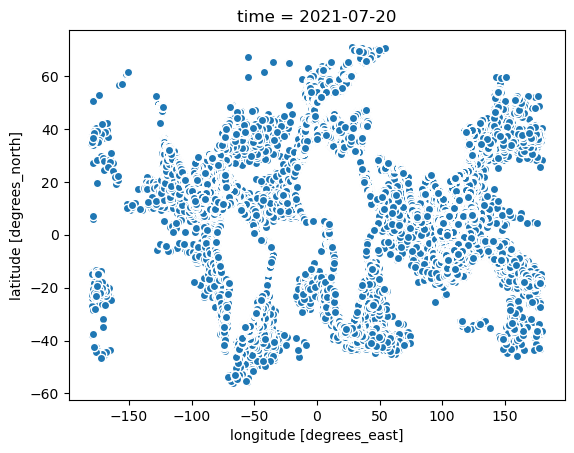

In [5]:
ds_full.isel(obs=200).plot.scatter(x="lon", y="lat")
plt.show()

Let's subset spacial domain of our analysis so that we can work with a smaller dataset. For the sake of this analysis, we are interested in particles that are in a bounding box in lon and lat off the East coast of South Africa. We also define a function which will help with plotting the dataset moving forward.

In [6]:
DOMAIN_LON = (30, 55)
DOMAIN_LAT = (-32, -8)


def scatter_traj_dataset(
    ds: xr.Dataset,
    color: xr.DataArray | None = None,
    ax: matplotlib.axes.Axes | None = None,
) -> matplotlib.axes.Axes:
    """Plot the lat/lon of the observations colouring based on `target` (if provided).

    Dataset should be in the obs/traj format in the form of an xr.Dataset.
    """
    if ax is None:
        _, ax = plt.subplots()
        ax.set_xlim(DOMAIN_LON)
        ax.set_ylim(DOMAIN_LAT)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    cmap_kwargs = {}
    if color is not None:
        cmap_kwargs = dict(c=color, cmap="viridis")

    ax.scatter(ds.lon, ds.lat, marker=".", **cmap_kwargs)
    return ax


def subset_particles(ds: xr.Dataset) -> xr.Dataset:
    """Subsets the particles to be only the particles that are always in the region of interest."""
    in_lon_domain = (ds.lon >= DOMAIN_LON[0]) & (ds.lon <= DOMAIN_LON[1])
    in_lat_domain = (ds.lat >= DOMAIN_LAT[0]) & (ds.lat <= DOMAIN_LAT[1])
    in_domain = in_lon_domain & in_lat_domain
    always_in_domain = in_domain.all(dim="obs")

    return ds.sel(traj=always_in_domain)


ds = ds_full.pipe(subset_particles)
ds

<xarray.Dataset> Size: 1MB
Dimensions:  (traj: 370, obs: 366)
Coordinates:
    time     (obs) datetime64[ns] 3kB ...
Dimensions without coordinates: traj, obs
Data variables:
    lon      (traj, obs) float32 542kB 33.06 33.1 33.14 ... 35.67 35.67 35.67
    lat      (traj, obs) float32 542kB -25.75 -25.48 -25.39 ... -18.97 -18.97
Attributes:
    title:         Global Marine Litter trajectories
    description:   Combined monthly releases of 32300 particles for 2021.
    institution:   FLorida State University Center for Ocean-Atmospheric Pred...
    references:    Chassignet, E. P., Xu, X., & Zavala-Romero, O. (2021), Tra...
    date_created:  2022-03-08T17:22:20.846777

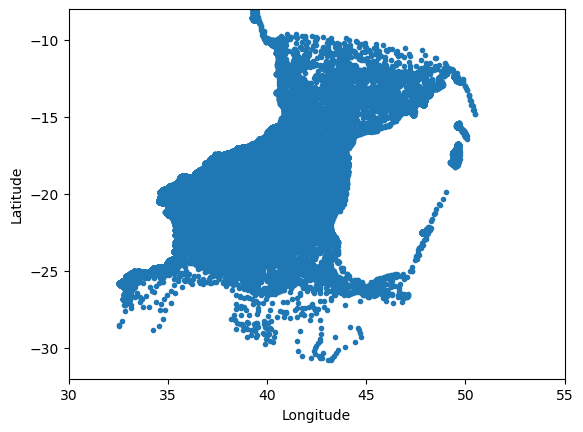

In [7]:
scatter_traj_dataset(ds)
plt.show()

## Per-observation analysis

Sometimes there are metrics that we want to compute for each observation in a trajectory dataset. Perhaps we're interested in if the observation is in a specific location (i.e., a calculation with lon/lat), or we are interested if another variable has a specific value.

This can be easily done with Xarray using array operations using conditional statements with the variables in our dataset. PLUS this has the benefit of being lazily computed via Dask, meaning the computation is only done when the result is needed during plotting or writing - win, win, win.

### Example: Northwards of a line

In [8]:
def north_of_line(
    ds: xr.Dataset, p0: Tuple[float, float], p1: Tuple[float, float]
) -> xr.DataArray:
    """Return a boolean array indicating whether each point is North of a line (specified by 2 points, extended infinitely).

    This line is simply a line between p0 and p1 in lon/lat space without accounting for earth curvature.

    Doesn't work for lines running directly North-South.
    """
    lon0, lat0 = p0
    lon1, lat1 = p1
    assert not np.isclose(np.array(p0), np.array(p1)).all(), "Points are the same"
    assert lon0 != lon1, "Doesn't work for vertical lines"

    m = (lat1 - lat0) / (lon1 - lon0)
    c = lat0 - m * lon0

    return ds.lat > m * ds.lon + c

<xarray.DataArray (traj: 370, obs: 366)> Size: 135kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(370, 366))
Coordinates:
    time     (obs) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2022-01-01
Dimensions without coordinates: traj, obs

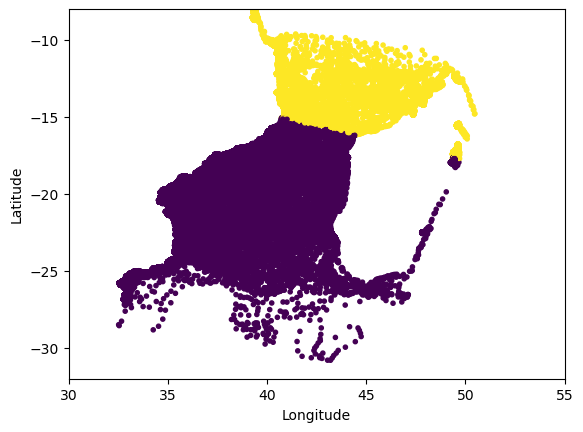

In [9]:
class Mozambique:
    lumbo = 40.70459126248918, -15.050879195437929
    angoche = 40.033176225110786, -16.21491412384874
    uetela = 35.523853583350785, -22.24430471935993
    marivate = 35.40813795799494, -23.715355944327616


class Madagascar:
    vilamatsa = 44.49393564261271, -16.201366344786088
    tambohorano = 44.0640566320765, -18.047257279582887


is_north_of_line = north_of_line(ds, p0=Mozambique.lumbo, p1=Madagascar.vilamatsa)
display(is_north_of_line)
scatter_traj_dataset(ds, color=is_north_of_line)
plt.show()

### Example: Within bands

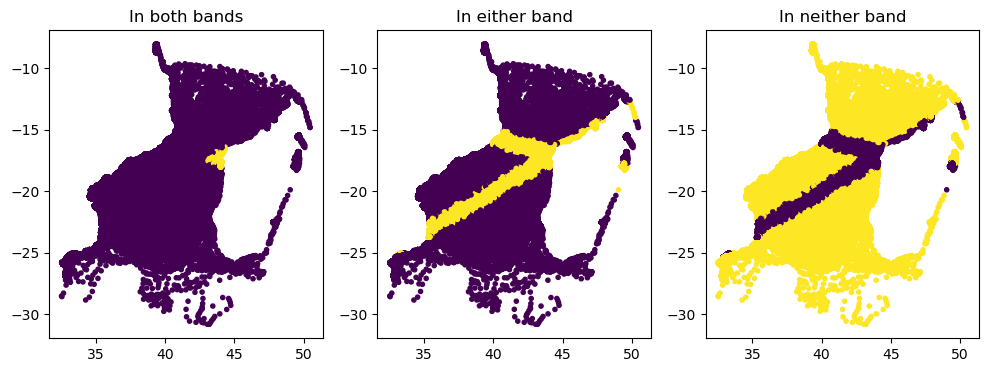

In [10]:
in_band1 = north_of_line(
    ds, p0=Mozambique.angoche, p1=Madagascar.tambohorano
) & ~north_of_line(ds, p0=Mozambique.lumbo, p1=Madagascar.vilamatsa)
in_band2 = north_of_line(
    ds, p0=Mozambique.marivate, p1=Madagascar.tambohorano
) & ~north_of_line(ds, p0=Mozambique.uetela, p1=Madagascar.vilamatsa)


fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].set_title("In both bands")
axs[1].set_title("In either band")
axs[2].set_title("In neither band")

scatter_traj_dataset(ds, color=(in_band1 & in_band2), ax=axs[0])
scatter_traj_dataset(ds, color=(in_band1 | in_band2), ax=axs[1])
scatter_traj_dataset(ds, color=(~in_band1 & ~in_band2), ax=axs[2])
plt.show()

### Example: More complex per-observation analysis

A common thing that we may want to do is calculate if a point is in a specific region, that isn't easily defined by simple lines in lat/lon space (e.g, to find if particles are in an Exclusive Economic Zone).

This can be done by levaging [Shapely](https://shapely.readthedocs.io/en/stable/), a package providing geospatial support in Python for vector features - points, lines, and polygons. As an FYI: Shapely is also used by [GeoPandas](https://geopandas.org/en/stable/), a popular package for working with tabular geospatial data in Python. Shapely by itself suffices for our purposes here, but since GeoPandas dataframes contain Shapely objects, you can easily extract individual Shapely polygons from these dataframes (and hence from shapefiles) for analysis similar to what we're doing here.



type(heart_polygon)=<class 'shapely.geometry.polygon.Polygon'>


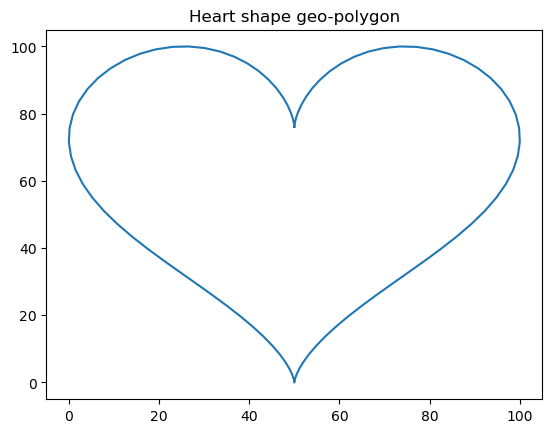

In [11]:
def plot_polygon(poly: shapely.geometry.Polygon, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(*poly.exterior.xy)
    return fig, ax


def in_polygon(ds, poly: shapely.geometry.Polygon) -> xr.DataArray:
    """Return a boolean array indicating whether each point is in the given polygon.

    `shapely.points(...)` allows for the creation of points from arrays of lon/lat
    `shapely.geometry.Polygon.contains` is also compatible with arrays of points
    """
    array = poly.contains(shapely.points(ds.lon, ds.lat))
    return xr.DataArray(
        array, coords=ds.coords
    )  # Adding back the dimension information, as shapely didn't carry it through


class TestData:
    """Ignore these methods. Only item of importance is that a shapely.geometry.Polygon is returned."""

    @staticmethod
    def get_heart_geo_polygon(xmin, xmax, ymin, ymax):
        """Return a shapely Polygon of a heart shape in the desired bounding box."""
        t = np.linspace(0, 2 * np.pi, 100)
        x = 16 * np.sin(t) ** 3
        y = 13 * np.cos(t) - 5 * np.cos(2 * t) - 2 * np.cos(3 * t) - np.cos(4 * t)
        heart_points = list(zip(x, y))

        x, y = zip(*heart_points)
        x, y = TestData.rescale_xy(x, y, xmin, xmax, ymin, ymax)
        return shapely.geometry.Polygon(zip(x, y))

    @staticmethod
    def rescale_xy(x, y, xmin, xmax, ymin, ymax):
        x = np.array(x)
        y = np.array(y)
        x = (x - x.min()) / (x.max() - x.min()) * (xmax - xmin) + xmin
        y = (y - y.min()) / (y.max() - y.min()) * (ymax - ymin) + ymin
        return x, y


heart_polygon = TestData.get_heart_geo_polygon(0, 100, 0, 100)

print(f"{type(heart_polygon)=}")

fig, ax = plot_polygon(heart_polygon)
ax.set_title("Heart shape geo-polygon")
plt.show()

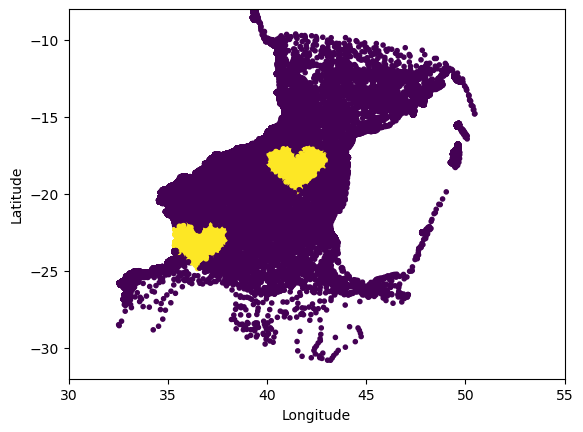

In [12]:
width_height = 3
in_hearts = in_polygon(
    ds, TestData.get_heart_geo_polygon(35, 35 + width_height, -25, -25 + width_height)
) | in_polygon(
    ds, TestData.get_heart_geo_polygon(40, 40 + width_height, -20, -20 + width_height)
)
scatter_traj_dataset(ds, color=in_hearts)

plt.show()

An important consideration here is one of projections. The Shapely object exists in lon/lat space which, for our latitude and analysis, is suitable. If we were working closer to the poles however, or if we needed greater accuracy, we could define the polygon using another projection. Then we would need to re-project the polygon into lon/lat space before using it in our analysis.

## Between observation analysis

We may want to compare an observation to the next observation. For example:

- calculating meriodonal or zonal velocity (degrees/s)
- if we want to see when particles are travelling in a specific direction
- seeing if particles are stationary
- if we want to see particles *crossing* a line (instead of if its simply above that line)

Fundamentally, these properties are no longer about the individual observations, but about the gaps between them. When taking the difference along the axes, the resulting array will be one shorter than the original array - hence we pad the beginning of the array to make them the same shape.

### Example: Going North

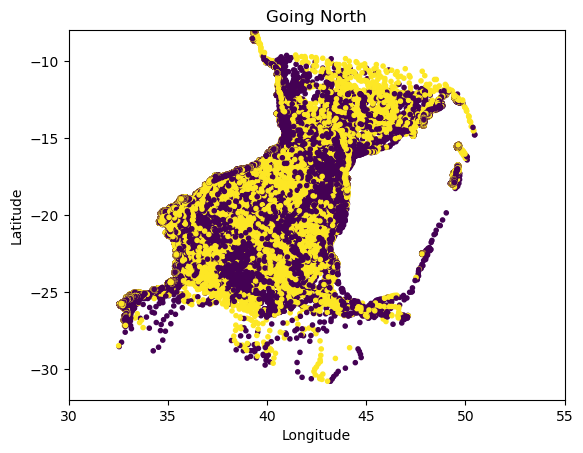

In [13]:
def going_north(ds: xr.Dataset) -> xr.DataArray:
    ds_diff = ds[["lon", "lat"]].diff(dim="obs")
    north = ds_diff.lat > 0
    return north.pad(pad_width={"obs": (1, 0)}, mode="constant", constant_values=False)


ax = scatter_traj_dataset(ds, going_north(ds).astype(int))
ax.set_title("Going North")
plt.show()

### Example: Particle is stuck

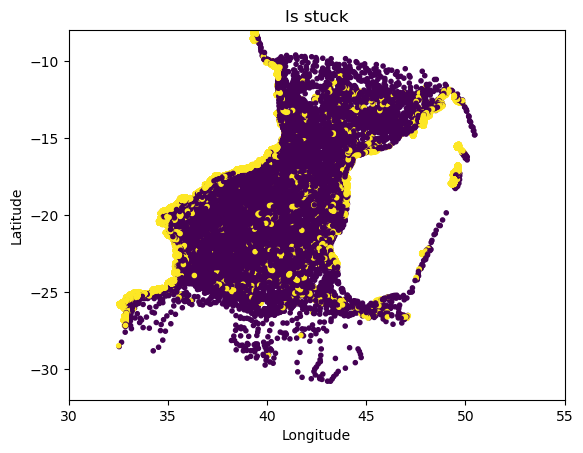

In [14]:
S_IN_1HOUR = 60 * 60


def is_stationary(ds: xr.Dataset) -> xr.DataArray:
    ds_diff = ds[["lon", "lat"]].diff(dim="obs")

    # time.diff returns delta in nanoseconds, so we convert to hours
    # if you want automatic unit-aware arithmetic, you can use pint-xarray (https://xarray.dev/blog/introducing-pint-xarray)
    dt = ds.time.diff("obs").dt.total_seconds() / S_IN_1HOUR
    ds_diff = ds_diff / dt

    cuttoff = 0.004
    stationary = (np.abs(ds_diff.lat) < cuttoff) & (np.abs(ds_diff.lon) < cuttoff)

    return stationary.pad(
        pad_width={"obs": (1, 0)}, mode="constant", constant_values=False
    )


ax = scatter_traj_dataset(ds, is_stationary(ds).astype(int))
ax.set_title("Is stuck")
plt.show()

### Example: Crossing into a region (timing, counting number of crossings, etc)

Taking the previous "boolean array" approach with particle positions, we can extend this idea to calculate crossing points for particles by taking the difference. From here, we can count total crossings, crossing out of, and crossings into a region. We can also look at the exact timings of these crossings.


In [15]:
def filter_to_particles_in_region(ds: xr.Dataset) -> xr.Dataset:
    """Remove all particles that don't enter the chosen region."""
    ds = ds.copy()
    in_band1 = north_of_line(
        ds, p0=Mozambique.angoche, p1=Madagascar.tambohorano
    ) & ~north_of_line(ds, p0=Mozambique.lumbo, p1=Madagascar.vilamatsa)
    in_band2 = north_of_line(
        ds, p0=Mozambique.marivate, p1=Madagascar.tambohorano
    ) & ~north_of_line(ds, p0=Mozambique.uetela, p1=Madagascar.vilamatsa)

    ds["in_x"] = in_band1 | in_band2
    ds["ever_in_x"] = ds["in_x"].any(dim="obs")

    # filter down to only the particles that enter the X
    ds = ds.sel(traj=ds.ever_in_x)
    return ds


particles_in_x = filter_to_particles_in_region(ds)

# Get the first occurence of max value (i.e., the 1 value in the boolean array)
obs_entering_x = particles_in_x["in_x"].argmax(dim="obs")

# Time that each particle enters the region of interest
particles_in_x.isel(obs=obs_entering_x).time.load()

<xarray.DataArray 'time' (traj: 225)> Size: 2kB
array(['2021-07-06T00:00:00.000000000', '2021-10-24T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-01-02T00:00:00.000000000',
       '2021-01-02T00:00:00.000000000', '2021-02-21T00:00:00.000000000',
       '2021-02-21T00:00:00.000000000', '2021-02-22T00:00:00.000000000',
       '2021-02-20T00:00:00.000000000', '2021-02-21T00:00:00.000000000',
       '2021-02-21T00:00:00.000000000', '2021-02-21T00:00:00.000000000',
       '2021-02-21T00:00:00.000000000', '2021-01-28T00:00:00.000000000',
       '2021-02-02T00:00:00.000000000', '2021-01-30T00:00:00.000000000',
       '2021-01-06T00:00:00.000000000', '2021-01-06T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-01-06T00:00:00.000000000',
       '2021-01-07T00:00:00.000000000', '2021-02-18T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-01-07T00:00:00.000000000', '2021-01-29T00:00:00.000000000',
       '2021-02-17T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-01-08T00:00:00.000000000', '2021-01-06T00:00:00.000000000',
       '2021-01-07T00:00:00.000000000', '2021-01-30T00:00:00.000000000',
       '2021-06-26T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-04-29T00:00:00.000000000', '2021-06-27T00:00:00.000000000',
       '2021-10-22T00:00:00.000000000', '2021-11-27T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2021-04-23T00:00:00.000000000',
...
       '2021-01-24T00:00:00.000000000', '2021-06-26T00:00:00.000000000',
       '2021-02-16T00:00:00.000000000', '2021-02-20T00:00:00.000000000',
       '2021-01-12T00:00:00.000000000', '2021-01-12T00:00:00.000000000',
       '2021-02-08T00:00:00.000000000', '2021-02-13T00:00:00.000000000',
       '2021-02-22T00:00:00.000000000', '2021-02-20T00:00:00.000000000',
       '2021-02-23T00:00:00.000000000', '2021-02-22T00:00:00.000000000',
       '2021-02-22T00:00:00.000000000', '2021-02-21T00:00:00.000000000',
       '2021-02-22T00:00:00.000000000', '2021-02-20T00:00:00.000000000',
       '2021-02-21T00:00:00.000000000', '2021-02-17T00:00:00.000000000',
       '2021-01-02T00:00:00.000000000', '2021-01-03T00:00:00.000000000',
       '2021-01-02T00:00:00.000000000', '2021-02-13T00:00:00.000000000',
       '2021-02-12T00:00:00.000000000', '2021-02-09T00:00:00.000000000',
       '2021-02-15T00:00:00.000000000', '2021-02-11T00:00:00.000000000',
       '2021-01-12T00:00:00.000000000', '2021-01-12T00:00:00.000000000',
       '2021-01-12T00:00:00.000000000', '2021-01-12T00:00:00.000000000',
       '2021-02-16T00:00:00.000000000', '2021-02-11T00:00:00.000000000',
       '2021-02-12T00:00:00.000000000', '2021-02-09T00:00:00.000000000',
       '2021-02-10T00:00:00.000000000', '2021-03-20T00:00:00.000000000',
       '2021-01-29T00:00:00.000000000', '2021-04-22T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    time     (traj) datetime64[ns] 2kB 2021-07-06 2021-10-24 ... 2021-01-01
Dimensions without coordinates: traj
Attributes:
    long_name:  time

In [16]:
# fmt: off
enter_exit = (
    particles_in_x['in_x'].astype(int) # Convert to 0/1 so that we can do arithmetic
    .diff(dim='obs') # Difference now represents crossing. Entering (1), leaving (-1), or neither (0)
    .pipe(np.abs).sum(dim='obs') # Count up all the crossings
    .rename("enter_exit")
)
display(enter_exit)

enter = (
    particles_in_x['in_x'].astype(int)
    .diff(dim='obs')
    .pipe(np.greater, 0).sum(dim='obs') # 1 for particles entering (1), 0 otherwise. Sum produces the count of particles entering
    .rename("enter")
)
display(enter)

exit = (
    particles_in_x['in_x'].astype(int)
    .diff(dim='obs')
    .pipe(np.less, 0).sum(dim='obs') # 1 for particles leaving (-1), 0 otherwise. Sum produces the count of particles leaving
    .rename("exit")
)
# fmt: on
display(exit)

assert np.all(enter_exit == enter + exit)

<xarray.DataArray 'enter_exit' (traj: 225)> Size: 2kB
array([14,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  4, 14,  6, 16,
       28, 17, 12,  6,  6,  9,  9,  8,  8,  6,  7, 10, 10,  4,  4, 10,  4,
       15,  2,  2,  3,  3, 13,  0,  0,  2, 10,  6,  0,  4,  3,  6,  4, 20,
       30,  4, 17,  1, 15,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  4,  4,  4, 10,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  8,
        2,  2,  2,  2,  2,  2,  8,  2,  2, 10,  2,  4,  4,  8, 35,  8,  6,
        3,  4,  6, 10, 10,  4,  6, 29, 12,  4, 10, 16, 12, 10,  7, 38, 10,
        9, 10, 14, 17, 19, 31,  7, 11,  5, 17,  9, 13,  6,  7,  5, 13, 11,
       18, 10,  8, 23, 10, 10,  8,  9, 10, 10, 10,  6, 12, 14, 16, 16,  8,
        6, 21, 11,  6, 12,  6,  6,  6,  6,  8, 16, 12, 10, 12, 13, 14, 24,
       11,  6,  8,  5, 23,  9, 13, 12,  8, 14, 14,  7, 16,  8, 10, 11,  8,
        4,  7,  4,  8,  2,  4,  3,  2,  6, 20,  2,  4,  2,  4,  4,  2, 28,
       16,  8, 10, 23, 16,  5, 17, 23,  4,  2, 19, 18, 18,  4, 26,  4,  4,
       14,  9,  4,  5])
Dimensions without coordinates: traj

<xarray.DataArray 'enter' (traj: 225)> Size: 2kB
array([ 7,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  7,  3,  8,
       14,  8,  6,  3,  3,  4,  4,  4,  4,  3,  3,  5,  5,  2,  2,  5,  2,
        8,  1,  1,  2,  1,  7,  0,  0,  1,  5,  3,  0,  2,  2,  3,  2, 10,
       15,  2,  9,  1,  8,  3,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  2,  2,  2,  5,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,
        1,  1,  1,  1,  1,  1,  4,  1,  1,  5,  1,  2,  2,  4, 18,  4,  3,
        2,  2,  3,  5,  5,  2,  3, 15,  6,  2,  5,  8,  6,  5,  4, 19,  5,
        5,  5,  7,  8, 10, 15,  3,  5,  2,  8,  4,  6,  3,  3,  2,  6,  5,
        9,  5,  4, 12,  5,  5,  4,  5,  5,  5,  5,  3,  6,  7,  8,  8,  4,
        3, 10,  5,  3,  6,  3,  3,  3,  3,  4,  8,  6,  5,  6,  7,  7, 12,
        6,  3,  4,  3, 11,  4,  6,  6,  4,  7,  7,  4,  8,  4,  5,  6,  4,
        2,  4,  2,  4,  1,  2,  2,  1,  3, 10,  1,  2,  1,  2,  2,  1, 14,
        8,  4,  5, 12,  8,  3,  9, 12,  2,  1, 10,  9,  9,  2, 13,  2,  2,
        7,  5,  2,  2])
Dimensions without coordinates: traj

<xarray.DataArray 'exit' (traj: 225)> Size: 2kB
array([ 7,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  7,  3,  8,
       14,  9,  6,  3,  3,  5,  5,  4,  4,  3,  4,  5,  5,  2,  2,  5,  2,
        7,  1,  1,  1,  2,  6,  0,  0,  1,  5,  3,  0,  2,  1,  3,  2, 10,
       15,  2,  8,  0,  7,  3,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,
        1,  2,  2,  2,  5,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,
        1,  1,  1,  1,  1,  1,  4,  1,  1,  5,  1,  2,  2,  4, 17,  4,  3,
        1,  2,  3,  5,  5,  2,  3, 14,  6,  2,  5,  8,  6,  5,  3, 19,  5,
        4,  5,  7,  9,  9, 16,  4,  6,  3,  9,  5,  7,  3,  4,  3,  7,  6,
        9,  5,  4, 11,  5,  5,  4,  4,  5,  5,  5,  3,  6,  7,  8,  8,  4,
        3, 11,  6,  3,  6,  3,  3,  3,  3,  4,  8,  6,  5,  6,  6,  7, 12,
        5,  3,  4,  2, 12,  5,  7,  6,  4,  7,  7,  3,  8,  4,  5,  5,  4,
        2,  3,  2,  4,  1,  2,  1,  1,  3, 10,  1,  2,  1,  2,  2,  1, 14,
        8,  4,  5, 11,  8,  2,  8, 11,  2,  1,  9,  9,  9,  2, 13,  2,  2,
        7,  4,  2,  3])
Dimensions without coordinates: traj

## Conclusion

Hopefully from this notebook you have begun to appreciate the power of Xarray and array programming when it comes to the data analysis of these types of datasets. There are many more operations available in Xarray - I highly recommend looking at the Xarray Tutorial website (https://tutorial.xarray.dev/intro.html) and have a think about how to apply these techniques to the data analysis work that you do.

If there are more examples that you would like to add to this notebook, feel free to submit a pull request.

### 